In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks")
Data_Dir = '/content/drive/My Drive/Colab Notebooks/images/synthetic_IslandDetection/'

In [0]:
import tensorflow as tf
import numpy as np 
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.initializers import glorot_uniform

import keras.backend as K
K.set_image_data_format('channels_last')
#K.set_learning_phase(1)

from keras.models import Model, load_model
from matplotlib import pyplot as plt
#from PIL import Image
#import matplotlib.image as mpimg

import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

from pathlib import Path

# In this notebook
- ResNet50 model is developed (with Keras/TensorFlow) and used to predict the existance of rectangular islands in a background image
- The data set is synthetic 

# Usefule references
- [Convolutional Neural Networks] (https://en.wikipedia.org/wiki/Convolutional_neural_network)
- [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift] (https://arxiv.org/pdf/1502.03167.pdf)
- [Rectified Linear Units] (https://en.wikipedia.org/wiki/Rectifier_(neural_networks))
- [Deep Residual Learning for Image Recognition] (https://arxiv.org/pdf/1512.03385.pdf)
- [Keras Documentation] (https://keras.io/)
- [TensorFlow main page] (https://www.tensorflow.org/)

# Data
- Synthetic (generated in this notebook)
  - First a background black square image is created. 
  - Then, rectangles of various shapes and sizes are patched on the square image to generate various samples. 
  - Some rectangles touch the boundary and some don't.
    - The ones that do not touch the boundary are islands (i.e. class 1); otherwise, the class is 0
    - About 30% of the cases are Islands. (Note: Another notebook looks at highly imbalanced classes for Island Detection)
- There are 70756 sample images and associated labels

# ResNet50 Implementation


## Identity Block 

In [0]:
def identity_block(InTensor, Kw, Nchn_out_lst, stage, block):
  
  '''
  Identity block for ResNet50
  
  Inputs
  ------
  (1) InTensor     : Input tensor for each layer
                   - Dimensions |  m       : Number of samples 
                                   Nrow    : Number of rows of the incoming 3d tensor
                                   Ncol    : Number of columns  of the incoming 3d tensor
                                   Nchn_in : Number of channels of the incoming 3d tensor
  (2) Kw           : Width of kernel (kernel shape is Kw x Kw)
  (3) Nchn_out_lst : List of 3 integers 
                   - There are 3 conv layers in each block. Each requires specifiying the number of filters (feature extractors) to be used. 
                   - Notes:
                          - Each filter (feature extractor) will have to have the same number of channels (Nchn_in) as the incoming tensor  
                          - Number of filters i.e. each integer in the list (Nch_out_list) becomes the Nchn_in for the next layer
  (4) stage        : The stage at which each instance of identity_block is used 
  (5) block        : The block at which each instance of the identity_block is used. 
                   - Note: blocks are subsets of stages
  Output
  ------
  tensor           : shape: (Nrow_out, Nclm_out, Nch_out)
  '''
  
  # Defining name basis
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'
  
  
  # First composite layer (Con--> BN --> Act) 
  X = Conv2D(filters = Nchn_out_lst[0], kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(InTensor)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
  X = Activation('relu')(X)
  
  # Second composite layer (Con--> BN --> Act) 
  X = Conv2D(filters = Nchn_out_lst[1], kernel_size = (Kw, Kw), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
  X = Activation('relu')(X)
  
  # Third composite layer (Con--> BN --> Act) 
  X = Conv2D(filters = Nchn_out_lst[2], kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

  
  # Add raw tensor to the processed tensor, and pass it through a RELU activation
  X = Add()([X , InTensor])
  X = Activation('relu')(X)
  

  return X

## Conv Block

In [0]:
def conv_block(InTensor, Kw, Nchn_out_lst, stage, block, s=2):
  '''
  Identity block for ResNet50
  
  Inputs
  ------
  (1) InTensor     : Input tensor for each layer
                   - Dimensions |  m       : Number of samples 
                                   Nrow_in : Number of rows of the incoming 3d tensor
                                   Ncol_in : Number of columns  of the incoming 3d tensor
                                   Nchn_in : Number of channels of the incoming 3d tensor
  (2) Kw           : Width of kernel (kernel shape is Kw x Kw)
  (3) Nchn_out_lst : List of 3 integers 
                   - There are 3 conv layers in each block. Each requires specifiying the number of filters (feature extractors) to be used. 
                     - Notes:
                          - Each filter (feature extractor) will have to have the same number of channels (Nchn_in) as the incoming tensor  
                          - Number of filters i.e. each integer in the list (Nch_out_list) becomes the Nchn_in for the next layer
  (4) stage        : The stage at which each instance of identity_block is used 
  (5) block        : The block at which each instance of the identity_block is used. 
                     - Note: blocks are subsets of stages
  (6) s            : stride used in the conv layer of the shortcut path 
  
  Output
  -----
  tensor           : shape: (Nrow_out, Nclm_out, Nch_out)
  '''
  
  # defining name basis
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'
  
  
  # First composite layer (Con--> BN --> Act) 
  X = Conv2D(filters = Nchn_out_lst[0], kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(InTensor)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
  X = Activation('relu')(X)
  
  # Second composite layer (Con--> BN --> Act) 
  X = Conv2D(filters = Nchn_out_lst[1], kernel_size = (Kw, Kw), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
  X = Activation('relu')(X)
  
  # Third composite layer (Con--> BN --> Act) 
  X = Conv2D(filters = Nchn_out_lst[2], kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
  
  
  # Short_cut path (Con--> BN) 
  X_shortcut = Conv2D(filters = Nchn_out_lst[2], kernel_size = (1, 1), strides = (s,s), padding = 'same', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(InTensor)
  X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)
  
  # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
  X = Add()([X , X_shortcut])
  X = Activation('relu')(X)
  
  return X
  

## Build Resent50 from identity and conv blocks

In [0]:
def ResNet50(input_shape = (20, 20, 1), classes = 2):
  '''
  Build ResNet50 from identity and conv blocks
  
  Inputs
  ------
  (1) input_shape : tuple containing the shape of the input with channels last
  (2) classes     : number of classes 
  
  Output
  ------
  model           : a  Model() instance in Keras
  '''
  
  # Define the input tensor placeholder based on the input_shape
  InTensor = Input(input_shape)
  
  # Initial layers of ResNet50 -----------------------
     
  # Zero-Padding
  X = ZeroPadding2D((3, 3))(InTensor)

  # Stage 1
  X = Conv2D(64, (7, 7), strides = (1, 1), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((3, 3), strides=(2, 2))(X)
  # --------------------------------------------------

  # Stage 2
  X = conv_block(X, Kw = 3, Nchn_out_lst = [64, 64, 256], stage = 2, block='a', s = 1)
  X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
  X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

  # Stage 3 
  X = conv_block(X, Kw=3, Nchn_out_lst = [128,128,512], stage = 3, block ='a', s = 2)
  X = identity_block(X, 3, [128,128,512], stage=3, block='b')
  X = identity_block(X, 3, [128,128,512], stage=3, block='c')
  X = identity_block(X, 3, [128,128,512], stage=3, block='d')

  # Stage 4
  X = conv_block(X, Kw=3, Nchn_out_lst = [256, 256, 1024], stage = 4, block ='a', s = 2)
  X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
  X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
  X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
  X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
  X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')


  # Stage 5 
  X = conv_block(X, Kw=3, Nchn_out_lst = [512, 512, 2048], stage = 5, block ='a', s = 2)
  X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
  X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

  # AVGPOOL
  X = AveragePooling2D(pool_size=(2,2))(X)



  # output layer
  X = Flatten()(X)
  X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)


  # Create model
  model = Model(inputs = InTensor, outputs = X, name='ResNet50')

  return model  

In [0]:
#model = ResNet50(input_shape = (64, 64, 1), classes=2)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Generate synthetic data

In [0]:
h_a = np.arange(1,15)
w_a = np.arange(1,15)
xs_a  = np.arange(0,19)
ys_a  = np.arange(0,19)


Ns = len(h_a) * len(w_a) * len(xs_a) * len(ys_a)

X  =  np.zeros((Ns,20,20,3))
y  =  np.zeros((Ns,))
idx = 0
for xs in xs_a:
    for ys in ys_a:
        for w in w_a:
            for h in h_a:
                # Define the rectangular shape which may or may not be an island
                X[idx, xs:xs+w+1 , ys:ys+h+1,0] = 1
                X[idx, xs:xs+w+1 , ys:ys+h+1,1] = 1
                X[idx, xs:xs+w+1 , ys:ys+h+1,2] = 1
                
                if xs>0 and (xs+w)<19 and ys>0 and (ys+h)<19:
                    y[idx] = 1
                #print(idx,"|", xs,xs+w , ys,ys+h, 'lablel:',y[idx])
                idx +=1
y = y.astype(int)


#  Randomize the data
np.random.seed(0)
random_indices = np.random.permutation(len(X))
X = X[random_indices]
y = y[random_indices].astype(int)

trn_frac = 0.85

X_train, X_val, y_train, y_val = X[:int(trn_frac*len(X))],X[int(trn_frac*len(X)):] , y[:int(trn_frac*len(X))], y[int(trn_frac*len(X)):]

print('Train:', X_train.shape, ' | ' , 'Val: ', X_val.shape)

Train: (60142, 20, 20, 3)  |  Val:  (10614, 20, 20, 3)


# Define a function to one-hot encode the labels

In [0]:
def OneHot(Vec, Nc):
  return np.eye(Nc)[Vec.reshape(-1)]

# Convert the labels to one-hot encoded format

In [0]:
y_train_1hot, y_val_1hot = OneHot(y_train, 2), OneHot(y_val,2)

# Class balances

In [0]:
print('train_minority_fraction:', round(sum(y_train)/len(y_train),2), '|'  , 'val_minority_fraction:' , round(sum(y_val)/len(y_val),2) )

train_minority_fraction: 0.3 | val_minority_fraction: 0.31


# Save the synthetic data as jpg images to file folders


In [0]:
os.chdir(Data_Dir)
!ls
'''
!mkdir train
!mkdir valid
!mkdir test

'''
!ls

trn_dir = f'{Data_Dir}train/' 
val_dir = f'{Data_Dir}valid/'
tst_dir = f'{Data_Dir}test/'

test  train  valid


# Generate subfolders for each class: 0 and 1 

In [0]:
os.chdir(trn_dir)
!mkdir Class0 Class1 

os.chdir(val_dir)
!mkdir Class0 Class1 


# Display a few samples 

Any image with the white rectangle not touching the boundary has an island (class 1), otherwise class is 0


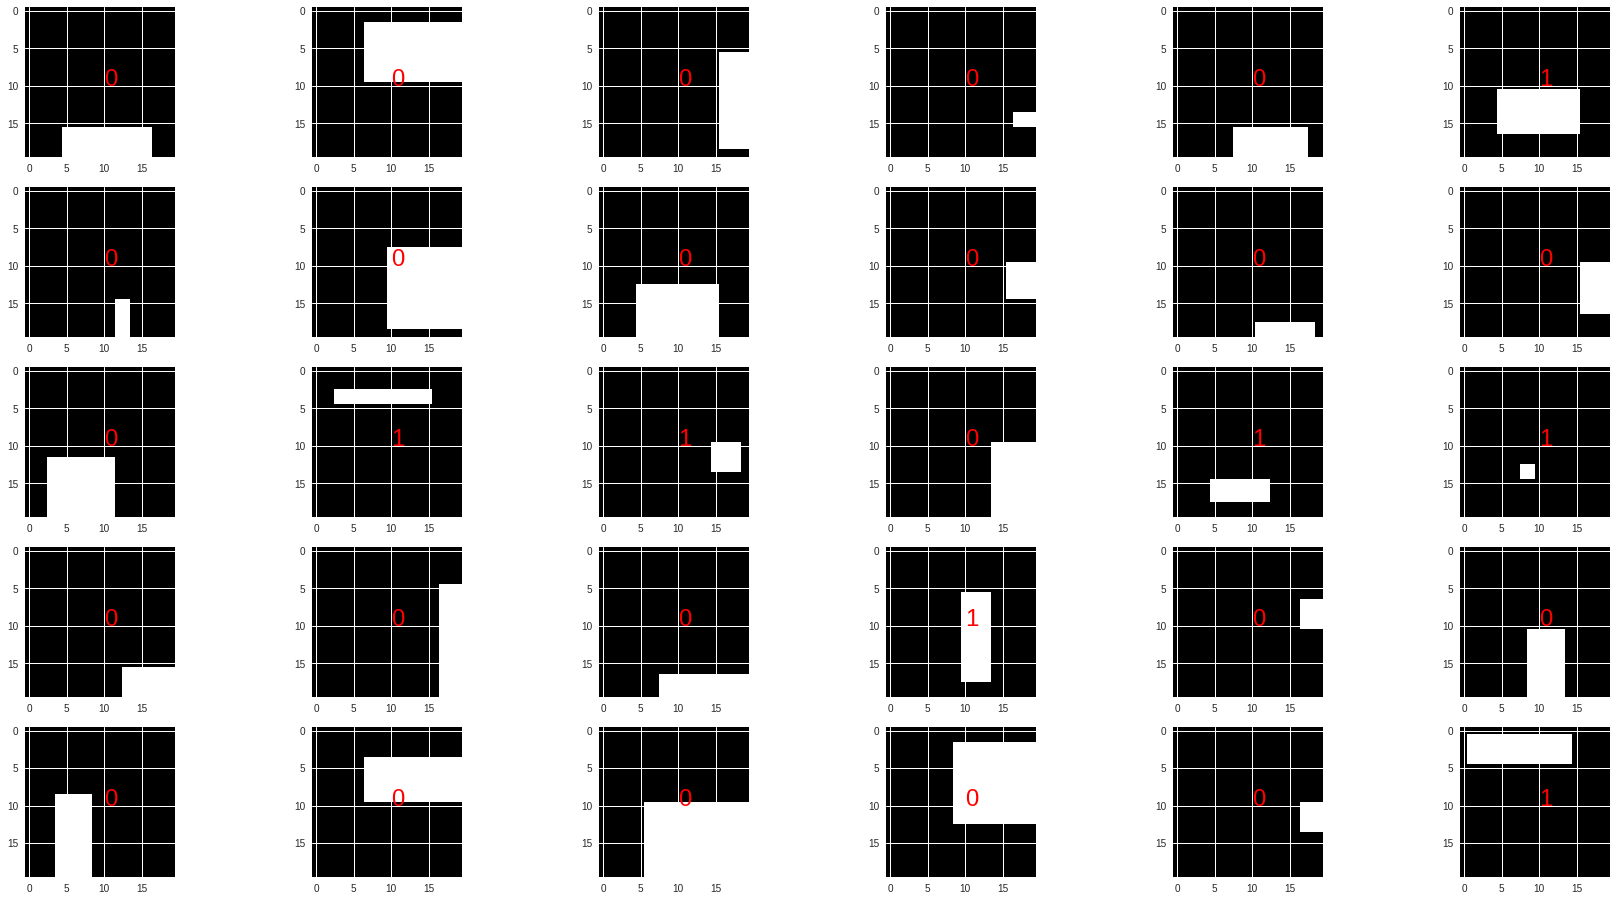

In [0]:
DATA   = X_train
LABELS = y_train

np.random.seed(117)
samples = np.random.randint(low=0,high=len(DATA), size=30)
samples

plt.figure(figsize=(30,16))

for ii in range(len(samples)):
    plt.subplot(5,6,ii+1)
    plt.imshow(DATA[samples[ii],:,:,0], cmap='gray')
    plt.text(10,10,f'{LABELS[samples[ii]]}',color='red', fontsize=24)
print('Any image with the white rectangle not touching the boundary has an island (class 1), otherwise class is 0')

# Function to save the synthetically generated tesors to directories

In [0]:
def saveTensorstoImages(Tensors, Labels, Dir):
  '''
  Saves the numpy arrays as images
  Each label has its own folder to be used by ImageDataGenerator
  '''
  
  idx0 = 0
  idx1 = 0
  for ii in range(Tensors.shape[0]):   
    img  = Tensors[ii]*255
    if Labels[ii] == 0: 
      cv2.imwrite(f'{Dir}Class0/{idx0}_C{Labels[ii]}.jpg',img)
      idx0 += 1
      
      
    if Labels[ii] == 1: 
      cv2.imwrite(f'{Dir}Class1/{idx1}_C{Labels[ii]}.jpg',img)
      idx1 += 1
  

# Save the data to separate trn/val/(tst) folders

In [0]:
# Training Data
print('Saving tensors to train folder ...')
saveTensorstoImages(X_train, y_train, trn_dir)


# Validation Data
print('Saving tensors to validation folder ...')
saveTensorstoImages(X_val, y_val, val_dir)

Saving tensors to train folder ...
Saving tensors to validation folder ...


# Use Resnet50 on recatangles in a square

# Fit with ImageDataGenerator
## Flow from directory

In [0]:
trn_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)


trn_generator = trn_datagen.flow_from_directory(
        trn_dir,
        target_size=(20, 20),
        batch_size=128,
        class_mode = 'categorical')

val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(20, 20),
        batch_size=128,
        class_mode = 'categorical')

model = ResNet50(input_shape = (20, 20, 3), classes=2)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit_generator(
      trn_generator,
      steps_per_epoch=900,
      epochs=2,
      validation_data = val_generator,
      validation_steps= 50)


Found 60142 images belonging to 2 classes.
Found 10614 images belonging to 2 classes.
Epoch 1/2
900/900 [==============================] - 911s 1s/step - loss: 0.0397 - acc: 0.9880 - val_loss: 4.8646e-06 - val_acc: 1.0000
Epoch 2/2
900/900 [==============================] - 886s 985ms/step - loss: 4.9733e-06 - acc: 1.0000 - val_loss: 8.4074e-07 - val_acc: 1.0000


# Generate predictions on the validation set for metrics extractions

In [0]:
val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(20, 20),
        batch_size=256,
        shuffle=False,
        class_mode='categorical')

predictions_probs , labels = model.predict_generator(val_generator, steps=40) , val_generator.classes
predictions_cls            = np.argmax(predictions_probs , axis=1)

Found 10614 images belonging to 2 classes.


# Calculate the confusion matrix

In [0]:
TN, FP, FN, TP = K.eval(tf.confusion_matrix(labels[:10000] , predictions_cls[:10000] , num_classes =2)).ravel()
TN, FP, FN, TP 

(7339, 0, 0, 2661)

# Precision, Recall, F1
## These results are for a minority class of 30%. As another notebook shows, highly imbalanced classes require other techniques to increase F1


In [0]:
PRC, RCL = np.round(TP/(TP+FP),2) ,  np.round(TP/(TP+FN), 2) 
F1       = np.round(2*(PRC*RCL)/(PRC+RCL),2)
print('Precision:', PRC, ' |' , 'Recall:',  RCL, ' |', 'F1: ', F1)

Precision: 1.0  | Recall: 1.0  | F1:  1.0


### Side note
- #####  x_train = np.vstack(df[dsv_column].values[0:m]).reshape((m, image_width, image_width, n_channels))